Test

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score

from scipy import sparse



directory = os.getcwd()
#set path for input DATA
data_path = os.path.join(directory, "data")
print(data_path)


artists_file = os.path.join(data_path, "artists.dat")
artists_spotify_file = os.path.join(data_path, "data_by_artist_o.csv")
tag_file = os.path.join(data_path, "tags.dat")
users_artists_file = os.path.join(data_path, "user_artists.dat")
users_tags_file = os.path.join(data_path, "user_taggedartists.dat")




/Users/Luis/Library/Mobile Documents/com~apple~CloudDocs/Documents/21_ISYE6740_CDA/Project/cda_recomm_project/data


In [3]:
#import data
artists_spotify_data = pd.read_csv(artists_spotify_file)
print("artists_spotify_data shape: ",artists_spotify_data.shape)

artists_data = pd.read_csv(artists_file,sep="\t")
print("artists_data shape: ",artists_data.shape)

tag_data = pd.read_csv(tag_file,sep="\t",encoding='latin-1')
print("tag_data shape: ",tag_data.shape)


users_artists_data = pd.read_csv(users_artists_file,sep="\t")
print("users_artists_data shape: ",users_artists_data.shape)


users_tags_data = pd.read_csv(users_tags_file,sep="\t")
print("users_tags_data shape: ",users_tags_data.shape)




artists_spotify_data shape:  (28680, 16)
artists_data shape:  (17632, 4)
tag_data shape:  (11946, 2)
users_artists_data shape:  (92834, 3)
users_tags_data shape:  (186479, 6)


In [4]:
artists_data.head()

,id,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...


In [5]:
#listening habits of artists. Weight = scrobbles = plays
users_artists_data

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983
...,...,...,...
92829,2100,18726,337
92830,2100,18727,297
92831,2100,18728,281
92832,2100,18729,280


In [6]:
#Sparse matrix, we need to pivot the data
data_pivot = users_artists_data.pivot(index='userID',
                                       columns='artistID').fillna(0).astype(int)
data_pivot.head()

weight                                                        ...  \
artistID  1     2     3     4     5     6     7     8     9     10     ...   
userID                                                                 ...   
2             0     0     0     0     0     0     0     0     0     0  ...   
3             0     0     0     0     0     0     0     0     0     0  ...   
4             0     0     0     0     0     0     0     0     0     0  ...   
5             0     0     0     0     0     0     0     0     0     0  ...   
6             0     0     0     0     0     0     0     0     0     0  ...   

                                                                      
artistID 18736 18737 18738 18739 18740 18741 18742 18743 18744 18745  
userID                                                                
2            0     0     0     0     0     0     0     0     0     0  
3            0     0     0     0     0     0     0     0     0     0  
4            0     0     0     0     0     0     0     0     0     0  
5            0     0     0     0     0     0     0     0     0     0  
6            0     0     0     0     0     0     0     0     0     0  

[5 rows x 17632 columns]

In [7]:
#Trying to make it more memory efficient
# create scipy sparse from pivot tables
data_sparse = sparse.csr_matrix(data_pivot)

In [79]:
#Quality Check


#user 2100, 3rd artist has 408 scrobbles
print(data_pivot)
print('\n')

#fist five artist scrobbles for user 2100
print (users_artists_data[users_artists_data['userID']==2100].head(5))
print('\n')


#user ID 2100 is now in the 1892th position
print('data_sparse shape',data_sparse.shape)
print('\n')

#ok 3rd artist (index 2) has 408 plays, 6th artist (index 5) has 404 plays
print(data_sparse[1891]) #index is 1892-1


         weight                                                        ...  \
artistID  1     2     3     4     5     6     7     8     9     10     ...   
userID                                                                 ...   
2             0     0     0     0     0     0     0     0     0     0  ...   
3             0     0     0     0     0     0     0     0     0     0  ...   
4             0     0     0     0     0     0     0     0     0     0  ...   
5             0     0     0     0     0     0     0     0     0     0  ...   
6             0     0     0     0     0     0     0     0     0     0  ...   
...         ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
2095          0     0     0     0     0     0     0     0     0     0  ...   
2096          0     0     0     0     0     0     0     0     0     0  ...   
2097          0     0     0     0     0     0     0     0     0     0  ...   
2099          0     0     0     0     0     0     0     0     0 

IndexError: row index (1891) out of range

In [11]:
#Merging some tables 
df_scrobbles = users_artists_data.merge(artists_data[['id','name']],
                               how = 'inner',
                               left_on = 'artistID',
                               right_on = 'id')


df_scrobbles = df_scrobbles.drop(columns=['id'])
df_scrobbles.columns = ['userID','artistID','scrobbles','name']

print(df_scrobbles.shape)
df_scrobbles.head()

(92834, 4)


,userID,artistID,scrobbles,name
0,2,51,13883,Duran Duran
1,4,51,228,Duran Duran
2,27,51,85,Duran Duran
3,28,51,10,Duran Duran
4,62,51,528,Duran Duran


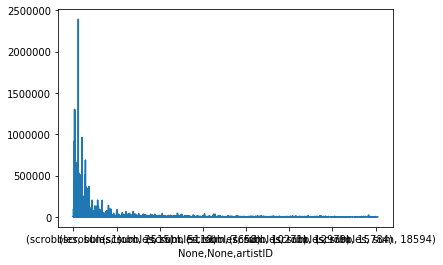

In [12]:
#Scrobble Distribution by artists:
artists_group = df_scrobbles.groupby('artistID').agg({'scrobbles': ['sum']})

artists_group.unstack().plot()
plt.show()

#Recommending popular artaists may not offer a personalized experience
#but models might learn a lot about that data because they show up in so many samples



In [13]:
#Potential Risk
#some users play lots of music. suppose their top artist was playe 10,000 times. 
#other users might be similar in preferences, with the same top artist, but with only 100 plays
#CAN WE NORMALIZE AT USER LEVEL? 
scrobbles_sorted = df_scrobbles.groupby('userID').agg({'scrobbles': ['min', 
                                                                  'max',
                                                                  'sum',
                                                                  'count']})

scrobbles_sorted
#for example. For userID 2: 13,383 represents their top artist
#for userID 6: 1,011 represet their top artist. If both top artists are Duran Duran
#then the data points wont be as close to each other when maybe they should???
#but if we scale the whole dataset the problem will remain suppose 13,383 gets converted
#to 1.383 and 1,011 gets converted to 0.101. 






scrobbles                     
             min    max     sum count
userID                               
2           1315  13883  168737    50
3             65  13176   20501    50
4            193   4983   26930    50
5            115    884   13159    50
6             13     41    1011    50
...          ...    ...     ...   ...
2095          31    548    4885    50
2096         336  14690   62714    50
2097         107   2628   13830    50
2099          72    770   10179    50
2100         228   2026   30877    50

[1892 rows x 4 columns]

## Clustering

In [14]:
print('total artists: ',len(artists_group))
threshold = 10
# flatten the hierarchical index in columns
artists_group.columns = ['_'.join(col).strip() for col in artists_group.columns.values]
artists_group.reset_index(level=0, inplace=True)
artists_group.head()


total artists:  17632


,artistID,scrobbles_sum
0,1,771
1,2,8012
2,3,775
3,4,563
4,5,913


In [15]:
artists_model = artists_group[artists_group['scrobbles_sum']>=threshold]
#modify matrix
print('original shape: ',users_artists_data.shape)
filtered_artists = users_artists_data.merge(artists_model['artistID'],
                                               how = 'inner',
                                               left_on = 'artistID',
                                               right_on = 'artistID')

print('new shape: ',filtered_artists.shape)

#Sparse matrix, we need to pivot the data
data_pivot = filtered_artists.pivot(index='userID',
                                       columns='artistID').fillna(0).astype(int)

print('pivot shape: ',data_pivot.shape)


#Trying to make it more memory efficient
# create scipy sparse from pivot tables
data_sparse = sparse.csr_matrix(data_pivot)

original shape:  (92834, 3)
new shape:  (92013, 3)
pivot shape:  (1888, 16817)


In [16]:
#to Numpy
#data_pivot.to_numpy()
#data_pivot.shape

In [17]:
# Collaborative Filtering Using Nearest Neighbors

''' 
NearestNeighbors implements unsupervised nearest neighbors learning. 
It acts as a uniform interface to three different nearest neighbors algorithms: BallTree,
KDTree, and a brute-force algorithm based on routines in sklearn.metrics.pairwise. 
The choice of neighbors search algorithm is controlled through the keyword 'algorithm',
which must be one of ['auto', 'ball_tree', 'kd_tree', 'brute']. When the default value 'auto' 
is passed, the algorithm attempts to determine the best approach from the training data. 

If there are some significant overlap between the two sets, we'd like the function to return a real number 
that is closer one (ex: 0.95) and vice versa the most dissimilar two sets of items are we want the items 
to approximate zero (ex: 0.05). Fortunately the positive values of cosine exhibit this behavior:
Cosine(0)   = 1.0   # 0 degrees angle
Cosine(π/4) ≈ 0.7   # 45 degrees angle
Cosine(π/2) = 0.0   # 90 degrees angle
https://www.linkedin.com/pulse/cosine-similarity-classification-michael-lin/
''' 


from sklearn.neighbors import NearestNeighbors

model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(data_sparse)
print(model_knn)

NearestNeighbors(algorithm='brute', metric='cosine')


In [115]:
#this data was not scaled, highly popular artists were included

query_index = np.random.choice(data_pivot.shape[0])#pick a row from matrix
user_vector = data_pivot.iloc[query_index,:].values.reshape(1,-1) #take artist lists 
user = data_pivot.index[query_index]

n_neighbors = 5

distances, indices = model_knn.kneighbors(user_vector, n_neighbors = n_neighbors)
#print(indices)

for i in range(0, n_neighbors):
    if i == 0:
        print('Neighbors for user {0}:\n'.format(user))
    else:
        #print('{0}: {1}, with distance of {2}:'.format(i, data_pivot.index[indices.flatten()[i]], distances.flatten()[i]))
         print('{0}: User {1}, with distance of {2}:'.format(i
                                                        #,artists_data[artists_data['id']==indices.flatten()[i]]['name'].values[0]
                                                        ,data_pivot.index[indices.flatten()[i]]
                                                        ,distances.flatten()[i]))


Neighbors for user 1505:

1: User 767, with distance of 0.12235570583477862:
2: User 2080, with distance of 0.1239312565202142:
3: User 446, with distance of 0.12448113316308762:
4: User 124, with distance of 0.12731665840070994:


In [116]:
#user top 10 artists
df_scrobbles[df_scrobbles['userID']==user].sort_values(by='scrobbles',ascending = False).head(10)  



,userID,artistID,scrobbles,name
2242,1505,72,13790,Depeche Mode
3844,1505,153,4964,De/Vision
27148,1505,518,2603,Within Temptation
53301,1505,1793,2206,Schiller
52593,1505,1713,1919,Dave Gahan
6968,1505,193,1682,Tears for Fears
89235,1505,15094,1524,Nerdette
20694,1505,378,1390,Evanescence
84845,1505,11529,1290,Sync24
41183,1505,1014,1119,Erasure


In [117]:
#closest neighbor top 10 artist
closest_neighbor = data_pivot.index[indices.flatten()[1]]
df_scrobbles[df_scrobbles['userID']==closest_neighbor].sort_values(by='scrobbles',ascending = False).head(10)  


,userID,artistID,scrobbles,name
2147,767,72,71852,Depeche Mode
42330,767,30,6316,And One
52578,767,1713,5741,Dave Gahan
6572,767,190,3257,Muse
5618,767,173,3144,Placebo
20618,767,378,1894,Evanescence
37427,767,880,1284,Nitzer Ebb
42503,767,1072,1274,Martin L. Gore
82399,767,9886,998,"Raz, Dwa, Trzy"
63863,767,3237,872,Hey


In [118]:
# 2nd closest neighbor top 10 artist
closest_neighbor = data_pivot.index[indices.flatten()[2]]
df_scrobbles[df_scrobbles['userID']==closest_neighbor].sort_values(by='scrobbles',ascending = False).head(10)  



,userID,artistID,scrobbles,name
2310,2080,72,80721,Depeche Mode
52602,2080,1713,6559,Dave Gahan
2531,2080,81,4869,Portishead
34685,2080,748,3384,Boards of Canada
208,2080,53,2087,Air
77997,2080,7470,1918,LFO
882,2080,59,1782,New Order
54428,2080,1893,1627,Yellow Magic Orchestra
74645,2080,6150,1313,Tangerine Dream
37435,2080,880,1226,Nitzer Ebb


In [ ]:
#Ok.... but how do we recommend an artist??



In [ ]:
#ok but what if I want the clusters and its info
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=200, random_state=0).fit(data_sparse)
kmeans.labels_

In [ ]:
#centroids
len(kmeans.cluster_centers_)